In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Bidirectional, Add, Conv1D, MaxPooling1D
from tensorflow.keras.layers import LayerNormalization, GlobalAveragePooling1D, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import wfdb
import os
import zipfile
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [2]:
def extract_datasets():
    STRESS_ZIP = r'C:\Users\Yatin\Downloads\mit-bih-noise-stress-test-database-1.0.0.zip'
    ARRHYTHMIA_ZIP = r'C:\Users\Yatin\Downloads\mit-bih-arrhythmia-database-1.0.0.zip'
    EXTRACT_PATH = r'C:\Users\Yatin\Downloads\extracted_data'

    os.makedirs(EXTRACT_PATH, exist_ok=True)  # Ensure the directory exists

    # Extract datasets safely
    for zip_path, name in [(STRESS_ZIP, "Stress"), (ARRHYTHMIA_ZIP, "Arrhythmia")]:
        if not os.path.exists(zip_path):
            print(f"Error: {name} dataset not found at {zip_path}")
            continue  # Skip extraction if file doesn't exist

        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(EXTRACT_PATH)
            print(f"{name} dataset extracted successfully.")
        except zipfile.BadZipFile:
            print(f"Error: {name} dataset ZIP file is corrupted.")
        except Exception as e:
            print(f"Unexpected error extracting {name} dataset: {e}")

    return EXTRACT_PATH

# Run extraction
extract_path = extract_datasets()
print(f"Datasets extracted to: {extract_path}")

class ECGDataLoader:
    def __init__(self, stress_path, arrhythmia_path, segment_length=1000, overlap=0.5):
        self.stress_path = stress_path
        self.arrhythmia_path = arrhythmia_path
        self.segment_length = segment_length
        self.overlap_ratio = overlap
        # Store class names for evaluation
        self.arrhythmia_class_names = ['Normal', 'Bundle Branch Block', 'Atrial Premature', 
                                       'Premature Ventricular Contraction', 'Fusion', 
                                       'Paced Beat', 'Ventricular Escape', 'Ventricular Flutter']
        self.stress_class_names = ['No Stress', 'Stress']

    def load_record(self, record_path, record_name):
        """Load a single record and its annotations"""
        try:
            # Read the signal
            record = wfdb.rdrecord(os.path.join(record_path, record_name))

            # Try to read annotations
            try:
                ann = wfdb.rdann(os.path.join(record_path, record_name), 'atr')
                return record.p_signal, ann
            except:
                return record.p_signal, None

        except Exception as e:
            print(f"Error loading {record_name}: {str(e)}")
            return None, None

    def preprocess_signal(self, signal):
        """Preprocess the ECG signal with overlapping windows and better normalization"""
        if signal is None:
            return None

        # Apply bandpass filter to remove noise
        from scipy.signal import butter, filtfilt

        def butter_bandpass(lowcut=0.5, highcut=50.0, fs=360.0, order=5):
            nyq = 0.5 * fs
            low = lowcut / nyq
            high = highcut / nyq
            b, a = butter(order, [low, high], btype='band')
            return b, a

        def apply_bandpass_filter(data):
            b, a = butter_bandpass()
            return filtfilt(b, a, data, axis=0)

        # Apply filter
        filtered_signal = apply_bandpass_filter(signal)

        # Robust normalization using median and IQR
        normalized_signal = np.zeros_like(filtered_signal)
        for i in range(filtered_signal.shape[1]):
            channel = filtered_signal[:, i]
            median = np.median(channel)
            iqr = np.percentile(channel, 75) - np.percentile(channel, 25)
            normalized_signal[:, i] = (channel - median) / (iqr + 1e-6)

        # Create overlapping segments
        stride = int(self.segment_length * (1 - self.overlap_ratio))
        segments = []
        for i in range(0, len(normalized_signal) - self.segment_length, stride):
            segment = normalized_signal[i:i + self.segment_length]
            segments.append(segment)

        return np.array(segments)

    def classify_arrhythmia(self, symbols, annotations):
        """Enhanced arrhythmia classification with temporal context"""
        # Expanded classification mapping
        arrhythmia_types = {
            'N': 0,  # Normal
            'L': 1,  # Left bundle branch block
            'R': 1,  # Right bundle branch block
            'A': 2,  # Atrial premature
            'V': 3,  # Premature ventricular contraction
            'F': 4,  # Fusion of ventricular and normal
            '/': 5,  # Paced beat
            'E': 6,  # Ventricular escape
            '!': 7   # Ventricular flutter
        }

        # Count occurrences with temporal weighting
        window_size = 10  # beats
        weighted_counts = {}

        for i, symbol in enumerate(symbols):
            if symbol in arrhythmia_types:
                # Calculate temporal weight (more recent beats have higher weight)
                temporal_weight = np.exp(-i/window_size)
                weighted_counts[symbol] = weighted_counts.get(symbol, 0) + temporal_weight

        # Determine primary arrhythmia type
        if not weighted_counts:
            return 0

        # Convert to multi-class label
        max_type = max(weighted_counts.items(), key=lambda x: x[1])[0]
        return arrhythmia_types[max_type]

    def load_datasets(self):
        """Load both stress and arrhythmia datasets with enhanced processing"""
        stress_segments = []
        arrhythmia_segments = []
        arrhythmia_labels = []

        # Load stress dataset
        print("\nLoading stress dataset...")
        stress_records = [f for f in os.listdir(self.stress_path) if f.endswith('.dat')]
        for record in stress_records:
            record_name = record[:-4]
            signal, _ = self.load_record(self.stress_path, record_name)
            if signal is not None:
                segments = self.preprocess_signal(signal)
                if segments is not None and len(segments) > 0:
                    stress_segments.extend(segments)

        # Load arrhythmia dataset
        print("\nLoading arrhythmia dataset...")
        arrhythmia_records = [f for f in os.listdir(self.arrhythmia_path) if f.endswith('.dat')]
        for record in arrhythmia_records:
            record_name = record[:-4]
            signal, ann = self.load_record(self.arrhythmia_path, record_name)
            if signal is not None and ann is not None:
                segments = self.preprocess_signal(signal)
                if segments is not None and len(segments) > 0:
                    arrhythmia_segments.extend(segments)
                    # Get labels for each segment
                    segment_labels = [self.classify_arrhythmia(ann.symbol[max(0, i-5):i+5], ann)
                                   for i in range(len(segments))]
                    arrhythmia_labels.extend(segment_labels)

        # Convert to numpy arrays
        stress_segments = np.array(stress_segments)
        arrhythmia_segments = np.array(arrhythmia_segments)
        arrhythmia_labels = np.array(arrhythmia_labels)

        print(f"\nLoaded {len(stress_segments)} stress segments")
        print(f"Loaded {len(arrhythmia_segments)} arrhythmia segments")

        return stress_segments, arrhythmia_segments, arrhythmia_labels

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.attention_weights = self.add_weight(
            name='attention_weights',
            shape=(input_shape[-1], 1),
            initializer='glorot_uniform',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs):
        # Calculate attention scores
        attention_score = tf.matmul(inputs, self.attention_weights)
        
        # Apply softmax to get attention weights
        attention_weights = tf.nn.softmax(attention_score, axis=1)
        
        # Apply attention weights to input
        context_vector = inputs * attention_weights
        
        return context_vector
    
    def compute_output_shape(self, input_shape):
        return input_shape


Stress dataset extracted successfully.
Arrhythmia dataset extracted successfully.
Datasets extracted to: C:\Users\Yatin\Downloads\extracted_data


In [3]:
def create_hybrid_cnn_lstm_model(input_shape, num_stress_classes=2, num_arrhythmia_classes=8):
    """Create a hybrid CNN-LSTM model for ECG analysis"""
    inputs = Input(shape=input_shape)
    
    # Initial normalization
    x = BatchNormalization()(inputs)
    
    # CNN Feature Extraction Path
    # First CNN block
    cnn = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(x)
    cnn = BatchNormalization()(cnn)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Dropout(0.2)(cnn)
    
    # Second CNN block
    cnn = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Dropout(0.2)(cnn)
    
    # Third CNN block
    cnn = Conv1D(filters=256, kernel_size=5, activation='relu', padding='same')(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Dropout(0.2)(cnn)
    
    # LSTM Sequence Modeling Path
    # First LSTM block
    lstm = Bidirectional(LSTM(64, return_sequences=True))(x)
    lstm = LayerNormalization()(lstm)
    lstm = Dropout(0.2)(lstm)
    
    # Second LSTM block
    lstm = Bidirectional(LSTM(32, return_sequences=True))(lstm)
    lstm = AttentionLayer()(lstm)
    lstm = LayerNormalization()(lstm)
    lstm = Dropout(0.2)(lstm)
    
    # Fusion of CNN and LSTM features
    # Reshape LSTM output to match CNN output dimensions if needed
    lstm_pooled = GlobalAveragePooling1D()(lstm)
    cnn_pooled = GlobalAveragePooling1D()(cnn)
    
    # Concatenate CNN and LSTM features
    fusion = Concatenate()([cnn_pooled, lstm_pooled])
    fusion = Dense(128, activation='relu')(fusion)
    fusion = BatchNormalization()(fusion)
    fusion = Dropout(0.3)(fusion)
    
    # Task-specific branches
    # Stress detection branch
    stress_hidden = Dense(64, activation='relu')(fusion)
    stress_hidden = BatchNormalization()(stress_hidden)
    stress_hidden = Dropout(0.3)(stress_hidden)
    stress_output = Dense(num_stress_classes, activation='softmax', name='stress_output')(stress_hidden)
    
    # Arrhythmia classification branch
    arrhythmia_hidden = Dense(128, activation='relu')(fusion)
    arrhythmia_hidden = BatchNormalization()(arrhythmia_hidden)
    arrhythmia_hidden = Dropout(0.3)(arrhythmia_hidden)
    arrhythmia_output = Dense(num_arrhythmia_classes, activation='softmax', name='arrhythmia_output')(arrhythmia_hidden)
    
    # Create model
    model = Model(inputs=inputs, outputs=[stress_output, arrhythmia_output])
    
    # Compile with separate metrics
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss={
            'stress_output': 'sparse_categorical_crossentropy',
            'arrhythmia_output': 'sparse_categorical_crossentropy'
        },
        loss_weights={
            'stress_output': 1.0,
            'arrhythmia_output': 1.0
        },
        metrics={
            'stress_output': ['accuracy'],
            'arrhythmia_output': ['accuracy']
        }
    )
    
    return model

# New function: Time series cross-validation evaluation
def evaluate_with_time_series_cv(model_func, X, y_stress, y_arr, n_splits=5, epochs=15, batch_size=32):
    """Evaluate model using time series cross-validation"""
    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Initialize metrics storage
    cv_stress_acc = []
    cv_arr_acc = []
    cv_stress_f1 = []
    cv_arr_f1 = []
    
    # For plotting
    fold_histories = []
    
    print(f"\nPerforming {n_splits}-fold time series cross-validation...")
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        print(f"\nFold {fold+1}/{n_splits}")
        
        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_stress_train, y_stress_val = y_stress[train_idx], y_stress[val_idx]
        y_arr_train, y_arr_val = y_arr[train_idx], y_arr[val_idx]
        
        # Create and compile model
        input_shape = X_train.shape[1:]
        model = model_func(input_shape)
        
        # Setup callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=0.0001,
                verbose=1
            )
        ]
        
        # Train model
        history = model.fit(
            X_train,
            {
                'stress_output': y_stress_train,
                'arrhythmia_output': y_arr_train
            },
            validation_data=(
                X_val,
                {
                    'stress_output': y_stress_val,
                    'arrhythmia_output': y_arr_val
                }
            ),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            callbacks=callbacks
        )
        
        # Evaluate on validation set
        y_pred = model.predict(X_val)
        stress_pred = np.argmax(y_pred[0], axis=1)
        arr_pred = np.argmax(y_pred[1], axis=1)
        
        # Calculate metrics
        stress_acc = accuracy_score(y_stress_val, stress_pred)
        arr_acc = accuracy_score(y_arr_val, arr_pred)
        stress_f1 = f1_score(y_stress_val, stress_pred, average='weighted')
        arr_f1 = f1_score(y_arr_val, arr_pred, average='weighted')
        
        # Store metrics
        cv_stress_acc.append(stress_acc)
        cv_arr_acc.append(arr_acc)
        cv_stress_f1.append(stress_f1)
        cv_arr_f1.append(arr_f1)
        
        # Store history for plotting
        fold_histories.append(history)
        
        print(f"Fold {fold+1} results:")
        print(f"Stress Detection - Accuracy: {stress_acc:.4f}, F1: {stress_f1:.4f}")
        print(f"Arrhythmia Classification - Accuracy: {arr_acc:.4f}, F1: {arr_f1:.4f}")
    
    # Calculate average metrics
    avg_stress_acc = np.mean(cv_stress_acc)
    avg_arr_acc = np.mean(cv_arr_acc)
    avg_stress_f1 = np.mean(cv_stress_f1)
    avg_arr_f1 = np.mean(cv_arr_f1)
    
    # Calculate standard deviation
    std_stress_acc = np.std(cv_stress_acc)
    std_arr_acc = np.std(cv_arr_acc)
    std_stress_f1 = np.std(cv_stress_f1)
    std_arr_f1 = np.std(cv_arr_f1)
    
    print("\nTime Series Cross-Validation Results:")
    print(f"Stress Detection - Avg Accuracy: {avg_stress_acc:.4f} ± {std_stress_acc:.4f}, Avg F1: {avg_stress_f1:.4f} ± {std_stress_f1:.4f}")
    print(f"Arrhythmia Classification - Avg Accuracy: {avg_arr_acc:.4f} ± {std_arr_acc:.4f}, Avg F1: {avg_arr_f1:.4f} ± {std_arr_f1:.4f}")
    
    # Plot cross-validation results
    plot_cv_results(fold_histories, cv_stress_acc, cv_arr_acc, cv_stress_f1, cv_arr_f1)
    
    cv_results = {
        'stress_acc': cv_stress_acc,
        'arr_acc': cv_arr_acc,
        'stress_f1': cv_stress_f1,
        'arr_f1': cv_arr_f1,
        'avg_stress_acc': avg_stress_acc,
        'avg_arr_acc': avg_arr_acc,
        'avg_stress_f1': avg_stress_f1,
        'avg_arr_f1': avg_arr_f1
    }
    
    return cv_results

def plot_cv_results(fold_histories, cv_stress_acc, cv_arr_acc, cv_stress_f1, cv_arr_f1):
    """Plot results from cross-validation"""
    # Plot metrics across folds
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    plt.bar(range(1, len(cv_stress_acc) + 1), cv_stress_acc)
    plt.axhline(y=np.mean(cv_stress_acc), color='r', linestyle='--', label=f'Mean: {np.mean(cv_stress_acc):.4f}')
    plt.title('Stress Detection Accuracy by Fold')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, len(cv_stress_acc) + 1))
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.bar(range(1, len(cv_arr_acc) + 1), cv_arr_acc)
    plt.axhline(y=np.mean(cv_arr_acc), color='r', linestyle='--', label=f'Mean: {np.mean(cv_arr_acc):.4f}')
    plt.title('Arrhythmia Classification Accuracy by Fold')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, len(cv_arr_acc) + 1))
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.bar(range(1, len(cv_stress_f1) + 1), cv_stress_f1)
    plt.axhline(y=np.mean(cv_stress_f1), color='r', linestyle='--', label=f'Mean: {np.mean(cv_stress_f1):.4f}')
    plt.title('Stress Detection F1 Score by Fold')
    plt.xlabel('Fold')
    plt.ylabel('F1 Score')
    plt.xticks(range(1, len(cv_stress_f1) + 1))
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.bar(range(1, len(cv_arr_f1) + 1), cv_arr_f1)
    plt.axhline(y=np.mean(cv_arr_f1), color='r', linestyle='--', label=f'Mean: {np.mean(cv_arr_f1):.4f}')
    plt.title('Arrhythmia Classification F1 Score by Fold')
    plt.xlabel('Fold')
    plt.ylabel('F1 Score')
    plt.xticks(range(1, len(cv_arr_f1) + 1))
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('time_series_cv_results.png', dpi=300)
    plt.show()
    
    # Plot learning curves for each fold
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    for i, history in enumerate(fold_histories):
        plt.plot(history.history['stress_output_accuracy'], label=f'Fold {i+1}')
    plt.title('Stress Detection Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    for i, history in enumerate(fold_histories):
        plt.plot(history.history['arrhythmia_output_accuracy'], label=f'Fold {i+1}')
    plt.title('Arrhythmia Classification Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(2, 2, 3)
    for i, history in enumerate(fold_histories):
        plt.plot(history.history['val_stress_output_accuracy'], label=f'Fold {i+1}')
    plt.title('Stress Detection Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    for i, history in enumerate(fold_histories):
        plt.plot(history.history['val_arrhythmia_output_accuracy'], label=f'Fold {i+1}')
    plt.title('Arrhythmia Classification Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('time_series_cv_learning_curves.png', dpi=300)
    plt.show()


In [4]:
def train_model(model, X_train, y_stress_train, y_arr_train, validation_split=0.2, epochs=15, batch_size=32):
    """Train the model with proper error handling and comprehensive monitoring"""
    # Create model checkpoint directory
    checkpoint_dir = 'model_checkpoints'
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Setup callbacks for better monitoring and model saving
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=0.0001,
            verbose=1
        ),
        ModelCheckpoint(
            filepath=os.path.join(checkpoint_dir, 'best_hybrid_model.h5'),
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]
    
    try:
        # Train model with callbacks
        history = model.fit(
            X_train,
            {
                'stress_output': y_stress_train,
                'arrhythmia_output': y_arr_train
            },
            validation_split=validation_split,
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            callbacks=callbacks
        )
        return history
    except Exception as e:
        print(f"Training error: {str(e)}")
        return None

def plot_training_history(history):
    """Visualize training metrics"""
    if history is None:
        print("No training history available to plot")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot training & validation accuracy values
    axes[0, 0].plot(history.history['stress_output_accuracy'])
    axes[0, 0].plot(history.history['val_stress_output_accuracy'])
    axes[0, 0].set_title('Stress Detection Accuracy')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].legend(['Train', 'Validation'], loc='upper left')
    
    axes[0, 1].plot(history.history['arrhythmia_output_accuracy'])
    axes[0, 1].plot(history.history['val_arrhythmia_output_accuracy'])
    axes[0, 1].set_title('Arrhythmia Classification Accuracy')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    axes[1, 0].plot(history.history['stress_output_loss'])
    axes[1, 0].plot(history.history['val_stress_output_loss'])
    axes[1, 0].set_title('Stress Detection Loss')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].legend(['Train', 'Validation'], loc='upper left')
    
    axes[1, 1].plot(history.history['arrhythmia_output_loss'])
    axes[1, 1].plot(history.history['val_arrhythmia_output_loss'])
    axes[1, 1].set_title('Arrhythmia Classification Loss')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.savefig('hybrid_model_training_history.png', dpi=300)
    plt.show()

def plot_confusion_matrices(model, X_test, y_stress_test, y_arr_test, loader):
    """Generate and plot confusion matrices for both tasks"""
    # Get predictions
    y_pred = model.predict(X_test)
    stress_pred = np.argmax(y_pred[0], axis=1)
    arr_pred = np.argmax(y_pred[1], axis=1)
    
    # Confusion matrix for stress detection
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    cm_stress = confusion_matrix(y_stress_test, stress_pred)
    sns.heatmap(cm_stress, annot=True, fmt='d', cmap='Blues', 
                xticklabels=loader.stress_class_names,
                yticklabels=loader.stress_class_names)
    plt.title('Stress Detection Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # Confusion matrix for arrhythmia classification
    plt.subplot(1, 2, 2)
    cm_arr = confusion_matrix(y_arr_test, arr_pred)
    sns.heatmap(cm_arr, annot=True, fmt='d', cmap='Blues',
                xticklabels=loader.arrhythmia_class_names,
                yticklabels=loader.arrhythmia_class_names)
    plt.title('Arrhythmia Classification Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.savefig('hybrid_model_confusion_matrices.png', dpi=300)
    plt.show()
    
    return cm_stress, cm_arr


In [5]:
def plot_roc_curves(model, X_test, y_stress_test, y_arr_test):
    """Generate and plot ROC curves for both tasks"""
    # Get predictions
    y_pred = model.predict(X_test)
    stress_pred_proba = y_pred[0]
    arr_pred_proba = y_pred[1]
    
    # Plot ROC curve for stress detection (binary)
    plt.figure(figsize=(12, 5))
    
    # Stress detection (binary classification)
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(y_stress_test, stress_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Stress Detection')
    plt.legend(loc="lower right")
    
    # Arrhythmia classification (multi-class)
    plt.subplot(1, 2, 2)
    # One-vs-Rest approach for multi-class ROC
    n_classes = arr_pred_proba.shape[1]
    
    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Convert y_arr_test to one-hot encoding for ROC calculation
    y_arr_test_oh = tf.keras.utils.to_categorical(y_arr_test, num_classes=n_classes)
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_arr_test_oh[:, i], arr_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.4f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve for Arrhythmia Classification')
    plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.savefig('hybrid_model_roc_curves.png', dpi=300)
    plt.show()
    
    return roc_auc

def plot_precision_recall_curves(model, X_test, y_stress_test, y_arr_test):
    """Generate and plot precision-recall curves for both tasks"""
    # Get predictions
    y_pred = model.predict(X_test)
    stress_pred_proba = y_pred[0]
    arr_pred_proba = y_pred[1]
    
    # Plot precision-recall curve for stress detection (binary)
    plt.figure(figsize=(12, 5))
    
    # Stress detection (binary classification)
    plt.subplot(1, 2, 1)
    precision, recall, _ = precision_recall_curve(y_stress_test, stress_pred_proba[:, 1])
    avg_precision = np.mean(precision)
    plt.plot(recall, precision, color='darkorange', lw=2, label=f'AP = {avg_precision:.4f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Stress Detection')
    plt.legend(loc="lower left")
    
    # Arrhythmia classification (multi-class)
    plt.subplot(1, 2, 2)
    # One-vs-Rest approach for multi-class PR curve
    n_classes = arr_pred_proba.shape[1]
    
    # Compute PR curve for each class
    precision = dict()
    recall = dict()
    avg_precision = dict()
    
    # Convert y_arr_test to one-hot encoding for PR calculation
    y_arr_test_oh = tf.keras.utils.to_categorical(y_arr_test, num_classes=n_classes)
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_arr_test_oh[:, i], arr_pred_proba[:, i])
        avg_precision[i] = np.mean(precision[i])
        plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AP = {avg_precision[i]:.4f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Multi-class Precision-Recall Curve for Arrhythmia Classification')
    plt.legend(loc="lower left")
    
    plt.tight_layout()
    plt.savefig('hybrid_model_precision_recall_curves.png', dpi=300)
    plt.show()
    
    return avg_precision


Loading stress dataset...

Loading arrhythmia dataset...

Loaded 19470 stress segments
Loaded 62304 arrhythmia segments
Original training set size: 65419
Augmented training set size: 130838


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1000, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1000, 2)   │          8 │ input_layer[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1000, 64)  │        704 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1000, 64)  │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 500, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 500, 64)   │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 500, 128)  │     41,088 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 500, 128)  │        512 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 1000, 128) │     34,304 │ batch_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 250, 128)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 1000, 128) │        256 │ bidirectional[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 250, 128)  │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 1000, 128) │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 250, 256)  │    164,096 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 1000, 64)  │     41,216 │ dropout_3[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 250, 256)  │      1,024 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 1000, 64)  │         64 │ bidirectional_1[… │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 125, 256)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1000, 64)  │        128 │ attention_layer[

 Total params: 351,954 (1.34 MB)

 Trainable params: 350,414 (1.34 MB)

 Non-trainable params: 1,540 (6.02 KB)


Performing 3-fold time series cross-validation...

Fold 1/3
Epoch 1/10
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 1210s 1s/step - arrhythmia_output_accuracy: 0.6940 - arrhythmia_output_loss: 1.0307 - loss: 1.3901 - stress_output_accuracy: 0.8523 - stress_output_loss: 0.3593 - val_arrhythmia_output_accuracy: 0.8982 - val_arrhythmia_output_loss: 0.3229 - val_loss: 0.4540 - val_stress_output_accuracy: 0.9582 - val_stress_output_loss: 0.1308 - learning_rate: 0.0010
Epoch 2/10
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 1171s 1s/step - arrhythmia_output_accuracy: 0.9118 - arrhythmia_output_loss: 0.2860 - loss: 0.4054 - stress_output_accuracy: 0.9520 - stress_output_loss: 0.1195 - val_arrhythmia_output_accuracy: 0.9410 - val_arrhythmia_output_loss: 0.1957 - val_loss: 0.2592 - val_stress_output_accuracy: 0.9738 - val_stress_output_loss: 0.0634 - learning_rate: 0.0010
Epoch 3/10
1023/1023 ━━━━━━━━━━━━━━━━━━━━ 1224s 1s/step - arrhythmia_output_accuracy: 0.9198 - arrhythmia_output_loss: 0.2555 - loss: 0.3563 - stress_o

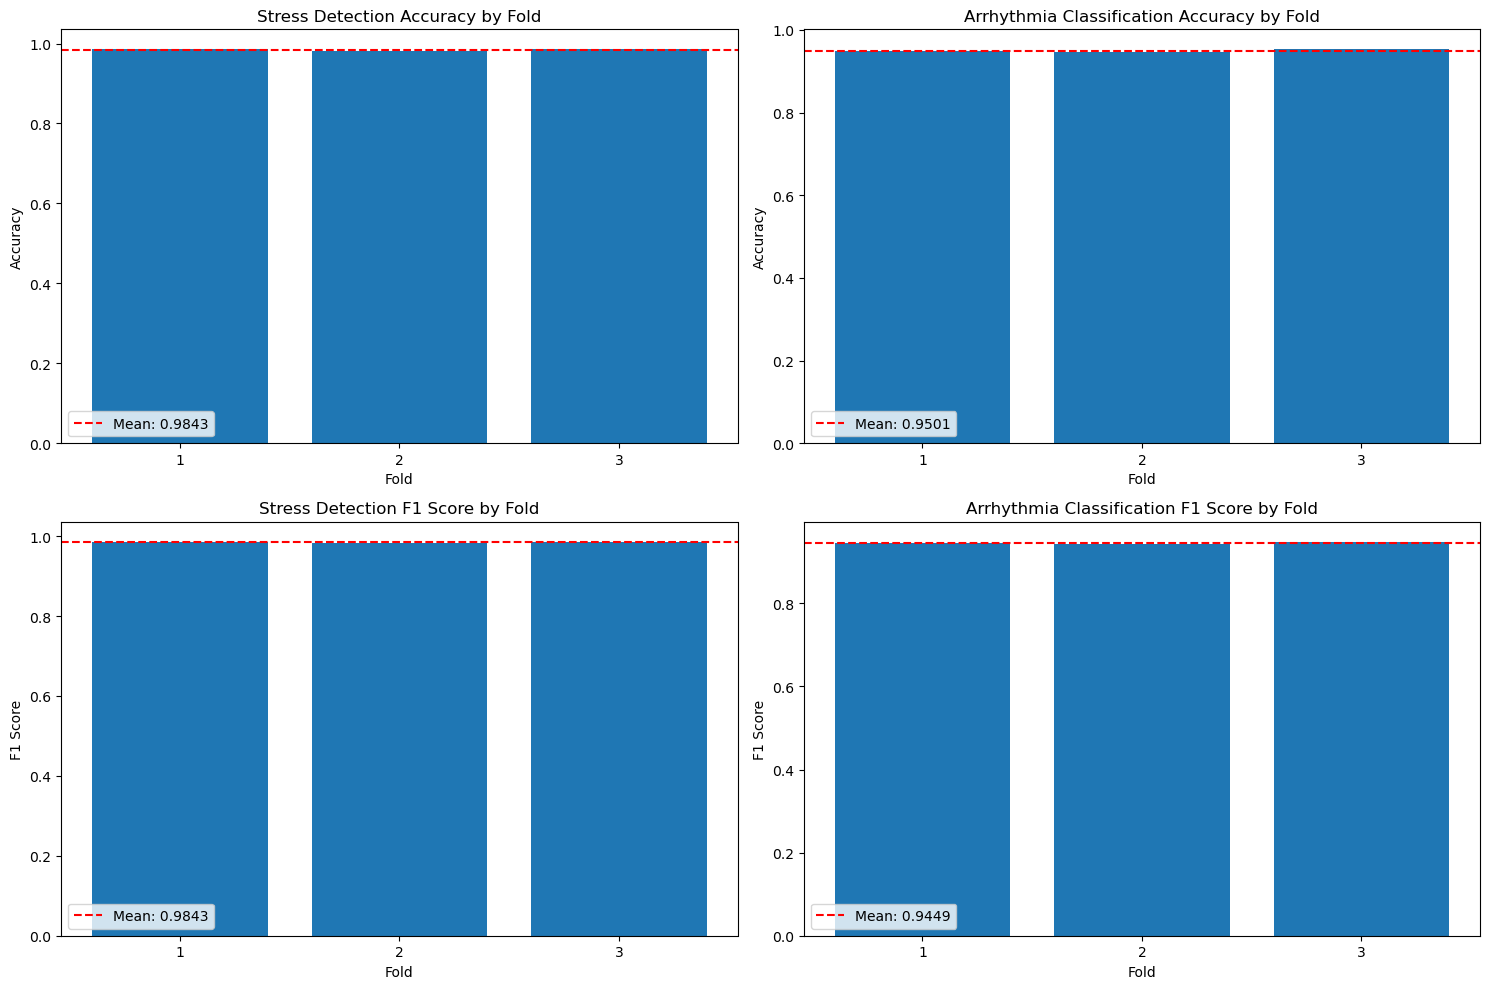

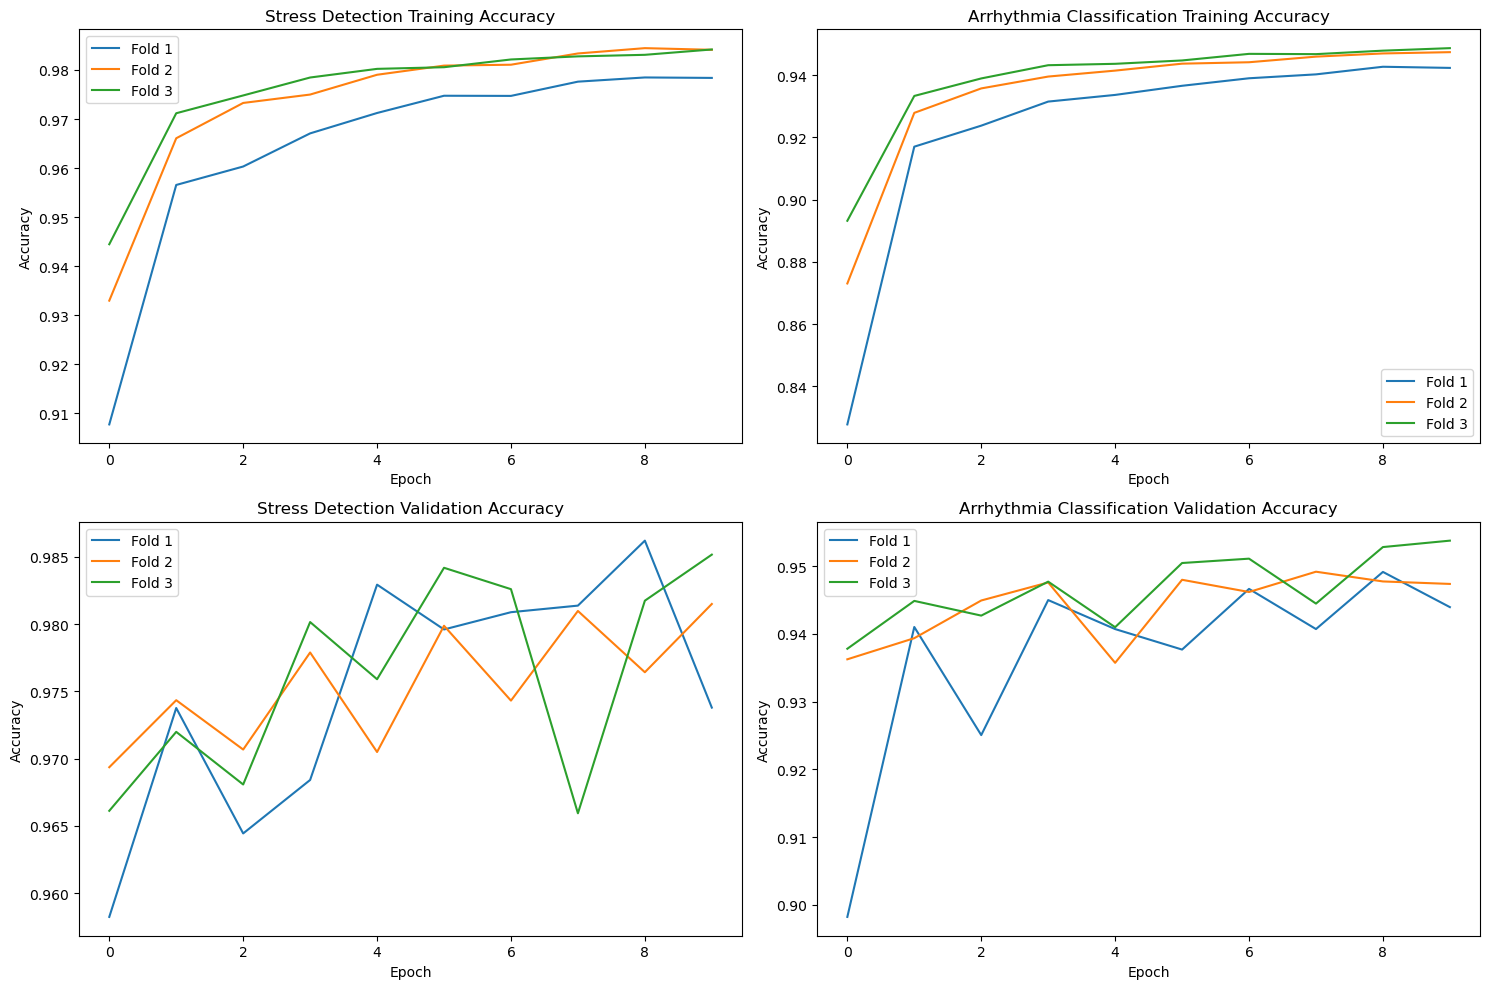

Epoch 1/10
3271/3271 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - arrhythmia_output_accuracy: 0.8166 - arrhythmia_output_loss: 0.6197 - loss: 0.8563 - stress_output_accuracy: 0.9081 - stress_output_loss: 0.2366
Epoch 1: val_loss improved from inf to 0.29762, saving model to model_checkpoints\best_hybrid_model.h5


3271/3271 ━━━━━━━━━━━━━━━━━━━━ 5587s 2s/step - arrhythmia_output_accuracy: 0.8166 - arrhythmia_output_loss: 0.6196 - loss: 0.8562 - stress_output_accuracy: 0.9081 - stress_output_loss: 0.2366 - val_arrhythmia_output_accuracy: 0.9295 - val_arrhythmia_output_loss: 0.2121 - val_loss: 0.2976 - val_stress_output_accuracy: 0.9603 - val_stress_output_loss: 0.0855 - learning_rate: 0.0010
Epoch 2/10
3271/3271 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - arrhythmia_output_accuracy: 0.9329 - arrhythmia_output_loss: 0.1994 - loss: 0.2739 - stress_output_accuracy: 0.9686 - stress_output_loss: 0.0744
Epoch 2: val_loss improved from 0.29762 to 0.20815, saving model to model_checkpoints\best_hybrid_model.h5


3271/3271 ━━━━━━━━━━━━━━━━━━━━ 13876s 4s/step - arrhythmia_output_accuracy: 0.9329 - arrhythmia_output_loss: 0.1994 - loss: 0.2739 - stress_output_accuracy: 0.9686 - stress_output_loss: 0.0744 - val_arrhythmia_output_accuracy: 0.9435 - val_arrhythmia_output_loss: 0.1519 - val_loss: 0.2082 - val_stress_output_accuracy: 0.9771 - val_stress_output_loss: 0.0563 - learning_rate: 0.0010
Epoch 3/10
3271/3271 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - arrhythmia_output_accuracy: 0.9389 - arrhythmia_output_loss: 0.1774 - loss: 0.2374 - stress_output_accuracy: 0.9746 - stress_output_loss: 0.0600
Epoch 3: val_loss improved from 0.20815 to 0.18104, saving model to model_checkpoints\best_hybrid_model.h5


3271/3271 ━━━━━━━━━━━━━━━━━━━━ 4501s 1s/step - arrhythmia_output_accuracy: 0.9389 - arrhythmia_output_loss: 0.1774 - loss: 0.2374 - stress_output_accuracy: 0.9746 - stress_output_loss: 0.0600 - val_arrhythmia_output_accuracy: 0.9486 - val_arrhythmia_output_loss: 0.1363 - val_loss: 0.1810 - val_stress_output_accuracy: 0.9793 - val_stress_output_loss: 0.0447 - learning_rate: 0.0010
Epoch 4/10
3271/3271 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - arrhythmia_output_accuracy: 0.9429 - arrhythmia_output_loss: 0.1611 - loss: 0.2127 - stress_output_accuracy: 0.9776 - stress_output_loss: 0.0516
Epoch 4: val_loss improved from 0.18104 to 0.17415, saving model to model_checkpoints\best_hybrid_model.h5


3271/3271 ━━━━━━━━━━━━━━━━━━━━ 4219s 1s/step - arrhythmia_output_accuracy: 0.9429 - arrhythmia_output_loss: 0.1611 - loss: 0.2127 - stress_output_accuracy: 0.9776 - stress_output_loss: 0.0516 - val_arrhythmia_output_accuracy: 0.9497 - val_arrhythmia_output_loss: 0.1324 - val_loss: 0.1742 - val_stress_output_accuracy: 0.9820 - val_stress_output_loss: 0.0418 - learning_rate: 0.0010
Epoch 5/10
3271/3271 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - arrhythmia_output_accuracy: 0.9450 - arrhythmia_output_loss: 0.1536 - loss: 0.2009 - stress_output_accuracy: 0.9796 - stress_output_loss: 0.0473
Epoch 5: val_loss did not improve from 0.17415
3271/3271 ━━━━━━━━━━━━━━━━━━━━ 4318s 1s/step - arrhythmia_output_accuracy: 0.9450 - arrhythmia_output_loss: 0.1536 - loss: 0.2009 - stress_output_accuracy: 0.9796 - stress_output_loss: 0.0473 - val_arrhythmia_output_accuracy: 0.9482 - val_arrhythmia_output_loss: 0.1356 - val_loss: 0.1758 - val_stress_output_accuracy: 0.9820 - val_stress_output_loss: 0.0402 - learning_

3271/3271 ━━━━━━━━━━━━━━━━━━━━ 4314s 1s/step - arrhythmia_output_accuracy: 0.9490 - arrhythmia_output_loss: 0.1353 - loss: 0.1714 - stress_output_accuracy: 0.9848 - stress_output_loss: 0.0361 - val_arrhythmia_output_accuracy: 0.9485 - val_arrhythmia_output_loss: 0.1265 - val_loss: 0.1729 - val_stress_output_accuracy: 0.9792 - val_stress_output_loss: 0.0465 - learning_rate: 5.0000e-04
Epoch 9/10
3271/3271 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - arrhythmia_output_accuracy: 0.9498 - arrhythmia_output_loss: 0.1325 - loss: 0.1654 - stress_output_accuracy: 0.9861 - stress_output_loss: 0.0330
Epoch 9: val_loss improved from 0.17294 to 0.14749, saving model to model_checkpoints\best_hybrid_model.h5


3271/3271 ━━━━━━━━━━━━━━━━━━━━ 4387s 1s/step - arrhythmia_output_accuracy: 0.9498 - arrhythmia_output_loss: 0.1325 - loss: 0.1654 - stress_output_accuracy: 0.9861 - stress_output_loss: 0.0330 - val_arrhythmia_output_accuracy: 0.9553 - val_arrhythmia_output_loss: 0.1173 - val_loss: 0.1475 - val_stress_output_accuracy: 0.9871 - val_stress_output_loss: 0.0302 - learning_rate: 5.0000e-04
Epoch 10/10
3271/3271 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - arrhythmia_output_accuracy: 0.9503 - arrhythmia_output_loss: 0.1297 - loss: 0.1635 - stress_output_accuracy: 0.9857 - stress_output_loss: 0.0338
Epoch 10: val_loss did not improve from 0.14749
3271/3271 ━━━━━━━━━━━━━━━━━━━━ 4500s 1s/step - arrhythmia_output_accuracy: 0.9503 - arrhythmia_output_loss: 0.1297 - loss: 0.1635 - stress_output_accuracy: 0.9857 - stress_output_loss: 0.0338 - val_arrhythmia_output_accuracy: 0.9497 - val_arrhythmia_output_loss: 0.1225 - val_loss: 0.1698 - val_stress_output_accuracy: 0.9786 - val_stress_output_loss: 0.0473 - lea

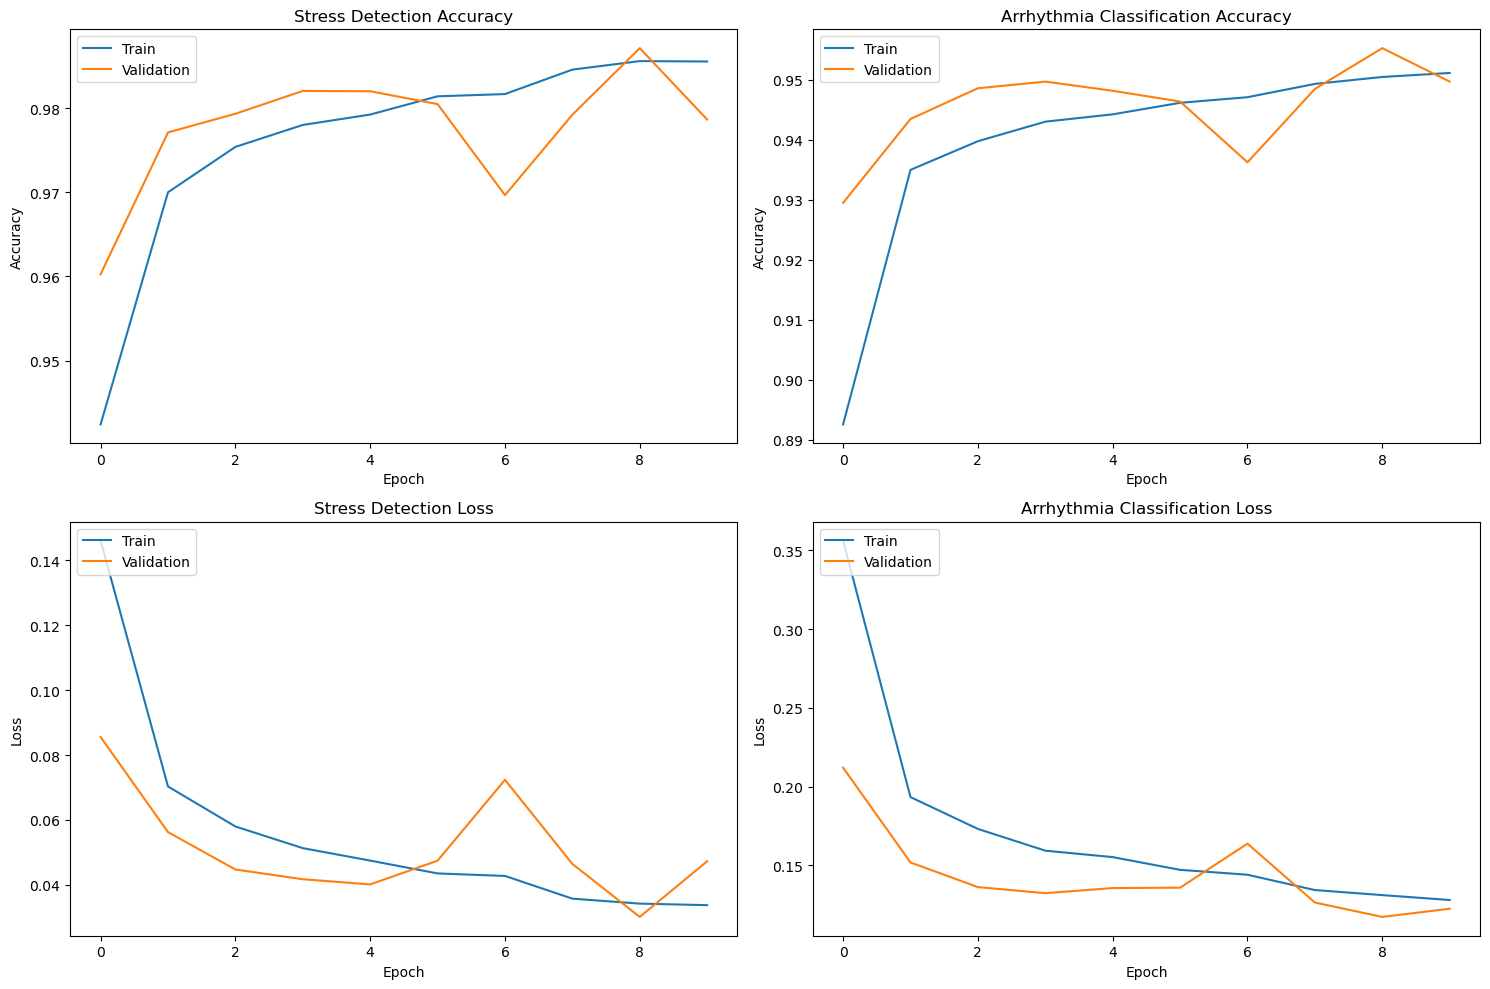

512/512 ━━━━━━━━━━━━━━━━━━━━ 157s 304ms/step


C:\Users\Yatin\anaconda3\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Yatin\anaconda3\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Yatin\anaconda3\New folder\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\User


Model Evaluation Metrics:
Stress Detection:
  Accuracy: 0.9921
  Precision: 0.9921
  Recall: 0.9921
  F1 Score: 0.9921

Arrhythmia Classification:
  Accuracy: 0.9548
  Precision: 0.9504
  Recall: 0.9548
  F1 Score: 0.9513

Detailed Stress Detection Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     12427
         1.0       0.99      0.98      0.98      3928

    accuracy                           0.99     16355
   macro avg       0.99      0.99      0.99     16355
weighted avg       0.99      0.99      0.99     16355


Detailed Arrhythmia Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97     12938
         1.0       0.88      0.98      0.93      1840
         2.0       0.97      0.86      0.91       316
         3.0       0.50      0.26      0.34       302
         4.0       0.00      0.00      0.00        23
         5.0       0.90      0.

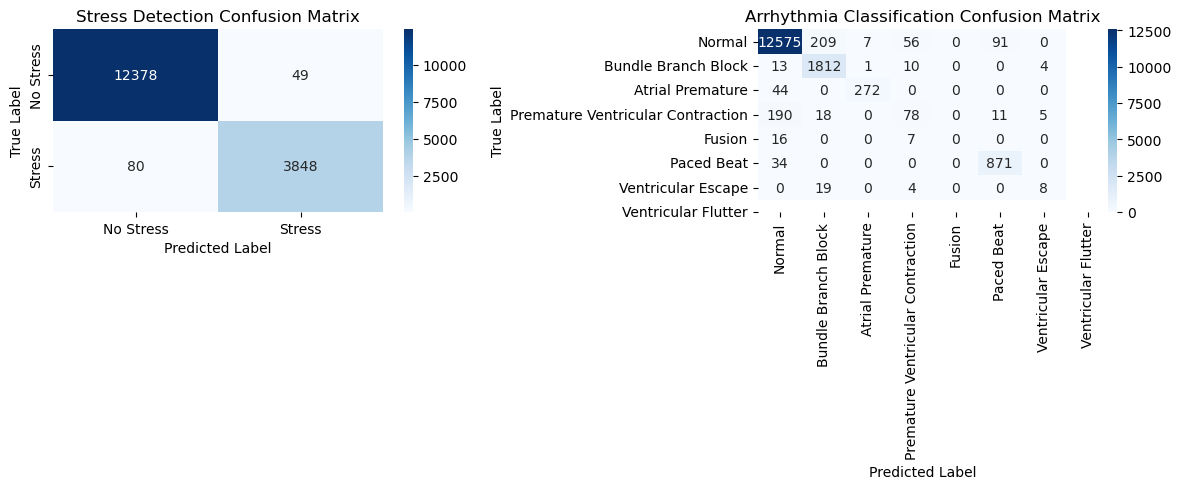

512/512 ━━━━━━━━━━━━━━━━━━━━ 122s 239ms/step


C:\Users\Yatin\anaconda3\New folder\Lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


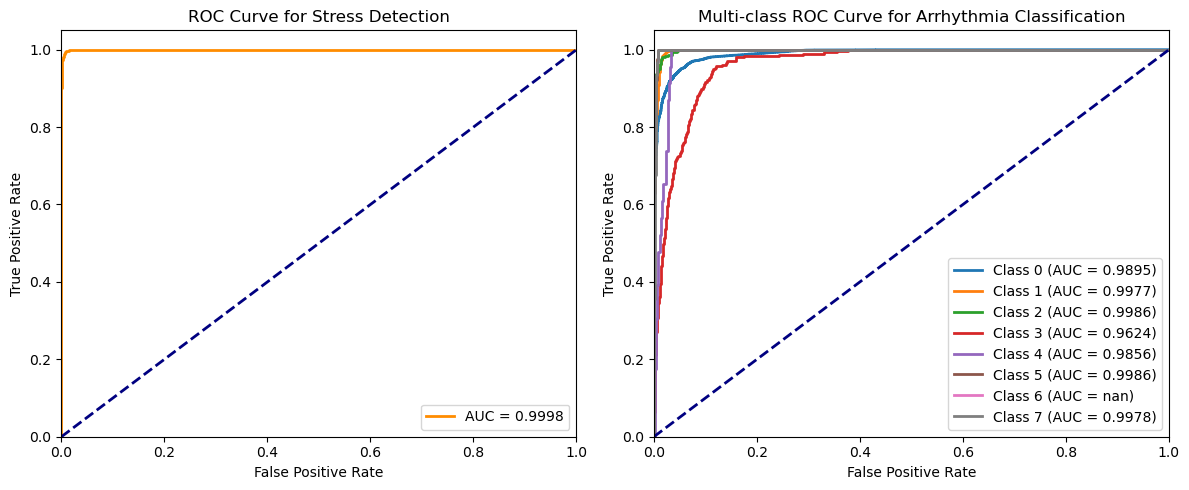

512/512 ━━━━━━━━━━━━━━━━━━━━ 141s 276ms/step


C:\Users\Yatin\anaconda3\New folder\Lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


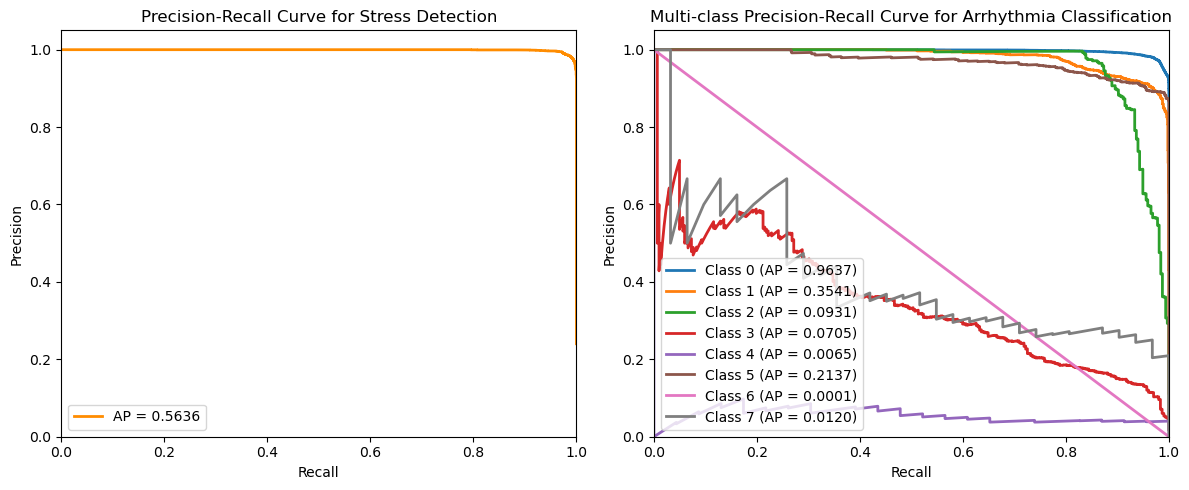

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


TypeError: Invalid shape (1000,) for image data

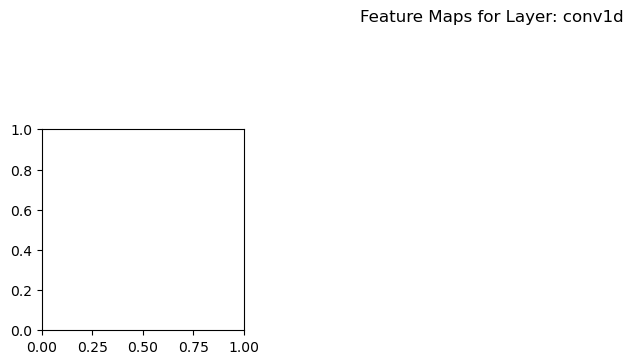

In [6]:
def calculate_metrics(model, X_test, y_stress_test, y_arr_test):
    """Calculate detailed metrics for model evaluation"""
    # Get predictions
    y_pred = model.predict(X_test)
    stress_pred = np.argmax(y_pred[0], axis=1)
    arr_pred = np.argmax(y_pred[1], axis=1)
    
    # Calculate metrics for stress detection
    stress_accuracy = accuracy_score(y_stress_test, stress_pred)
    stress_precision = precision_score(y_stress_test, stress_pred, average='weighted')
    stress_recall = recall_score(y_stress_test, stress_pred, average='weighted')
    stress_f1 = f1_score(y_stress_test, stress_pred, average='weighted')
    
    # Calculate metrics for arrhythmia classification
    arr_accuracy = accuracy_score(y_arr_test, arr_pred)
    arr_precision = precision_score(y_arr_test, arr_pred, average='weighted')
    arr_recall = recall_score(y_arr_test, arr_pred, average='weighted')
    arr_f1 = f1_score(y_arr_test, arr_pred, average='weighted')
    
    # Print metrics
    print("\nModel Evaluation Metrics:")
    print("Stress Detection:")
    print(f"  Accuracy: {stress_accuracy:.4f}")
    print(f"  Precision: {stress_precision:.4f}")
    print(f"  Recall: {stress_recall:.4f}")
    print(f"  F1 Score: {stress_f1:.4f}")
    
    print("\nArrhythmia Classification:")
    print(f"  Accuracy: {arr_accuracy:.4f}")
    print(f"  Precision: {arr_precision:.4f}")
    print(f"  Recall: {arr_recall:.4f}")
    print(f"  F1 Score: {arr_f1:.4f}")
    
    # Generate classification reports
    print("\nDetailed Stress Detection Classification Report:")
    print(classification_report(y_stress_test, stress_pred))
    
    print("\nDetailed Arrhythmia Classification Report:")
    print(classification_report(y_arr_test, arr_pred))
    
    metrics = {
        'stress': {
            'accuracy': stress_accuracy,
            'precision': stress_precision,
            'recall': stress_recall,
            'f1': stress_f1
        },
        'arrhythmia': {
            'accuracy': arr_accuracy,
            'precision': arr_precision,
            'recall': arr_recall,
            'f1': arr_f1
        }
    }
    
    return metrics

def visualize_feature_maps(model, X_sample, layer_names=None):
    """Visualize feature maps from convolutional layers"""
    if layer_names is None:
        # Find all convolutional layers
        layer_names = [layer.name for layer in model.layers if 'conv' in layer.name.lower()]
    
    if not layer_names:
        print("No convolutional layers found in the model")
        return
    
    # Create feature extraction models
    feature_models = {}
    for layer_name in layer_names:
        try:
            feature_models[layer_name] = Model(
                inputs=model.input,
                outputs=model.get_layer(layer_name).output
            )
        except Exception as e:
            print(f"Error creating feature model for layer {layer_name}: {str(e)}")
    
    # Get a sample input
    if len(X_sample.shape) == 2:  # Single sample, make it batch
        X_sample = np.expand_dims(X_sample, axis=0)
    elif len(X_sample.shape) == 3 and X_sample.shape[0] > 1:  # Use only first sample
        X_sample = X_sample[0:1]
    
    # Compute feature maps
    feature_maps = {}
    for layer_name, feature_model in feature_models.items():
        try:
            feature_maps[layer_name] = feature_model.predict(X_sample)
        except Exception as e:
            print(f"Error computing features for layer {layer_name}: {str(e)}")
    
    # Plot feature maps
    for layer_name, feature_map in feature_maps.items():
        # Get number of features in this layer
        n_features = feature_map.shape[-1]
        
        # Plot up to 16 features in a 4x4 grid
        n_cols = min(4, n_features)
        n_rows = min(4, (n_features + n_cols - 1) // n_cols)
        
        plt.figure(figsize=(n_cols * 3, n_rows * 3))
        plt.suptitle(f'Feature Maps for Layer: {layer_name}')
        
        for i in range(n_rows * n_cols):
            if i < n_features:
                plt.subplot(n_rows, n_cols, i + 1)
                plt.imshow(feature_map[0, :, i], aspect='auto', cmap='viridis')
                plt.title(f'Feature {i+1}')
                plt.colorbar()
                plt.tight_layout()
            else:
                break
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for suptitle
        plt.savefig(f'feature_maps_{layer_name}.png', dpi=300)
        plt.show()

def interpret_attention_weights(model, X_sample, attention_layer_name=None):
    """Visualize and interpret attention weights"""
    # Find attention layer if not specified
    if attention_layer_name is None:
        attention_layer_names = [layer.name for layer in model.layers if 'attention' in layer.name.lower()]
        if not attention_layer_names:
            print("No attention layer found in the model")
            return
        attention_layer_name = attention_layer_names[0]
    
    # Get a sample input
    if len(X_sample.shape) == 2:  # Single sample, make it batch
        X_sample = np.expand_dims(X_sample, axis=0)
    elif len(X_sample.shape) == 3 and X_sample.shape[0] > 1:  # Use only first sample
        X_sample = X_sample[0:1]
    
    # Create a model that outputs attention weights
    try:
        attention_layer = model.get_layer(attention_layer_name)
        # Extract attention weights (this will be model-specific)
        # For our custom attention layer
        attention_weights = attention_layer.attention_weights
        print(f"Attention weights shape: {attention_weights.shape}")
        
        # Visualize attention weights
        plt.figure(figsize=(10, 6))
        plt.imshow(attention_weights.numpy(), aspect='auto', cmap='hot')
        plt.colorbar(label='Weight Magnitude')
        plt.title(f'Attention Weights for Layer: {attention_layer_name}')
        plt.xlabel('Feature Dimension')
        plt.tight_layout()
        plt.savefig('attention_weights.png', dpi=300)
        plt.show()
        
    except Exception as e:
        print(f"Error interpreting attention weights: {str(e)}")
        print("This interpretation function needs to be customized based on the specific attention implementation.")

def save_model_with_metadata(model, metadata, base_path='saved_model'):
    """Save the model with metadata for later use"""
    # Create directory if it doesn't exist
    os.makedirs(base_path, exist_ok=True)
    
    # Save the model
    model_path = os.path.join(base_path, 'hybrid_ecg_model.h5')
    try:
        model.save(model_path)
        print(f"Model saved to {model_path}")
    except Exception as e:
        print(f"Error saving model: {str(e)}")
        
    # Save metadata as JSON
    metadata_path = os.path.join(base_path, 'metadata.json')
    try:
        import json
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)
        print(f"Metadata saved to {metadata_path}")
    except Exception as e:
        print(f"Error saving metadata: {str(e)}")

def load_saved_model(base_path='saved_model'):
    """Load a saved model with metadata"""
    # Load model
    model_path = os.path.join(base_path, 'hybrid_ecg_model.h5')
    try:
        model = load_model(model_path, custom_objects={'AttentionLayer': AttentionLayer})
        print(f"Model loaded from {model_path}")
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return None, None
    
    # Load metadata
    metadata_path = os.path.join(base_path, 'metadata.json')
    try:
        import json
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        print(f"Metadata loaded from {metadata_path}")
    except Exception as e:
        print(f"Error loading metadata: {str(e)}")
        metadata = None
    
    return model, metadata

def batch_predict(model, data_loader, batch_size=32):
    """Make predictions on large datasets in batches to avoid memory issues"""
    all_stress_preds = []
    all_arr_preds = []
    
    # Create a generator to process data in batches
    def batch_generator(data, batch_size):
        for i in range(0, len(data), batch_size):
            yield data[i:i + batch_size]
    
    # Iterate through batches
    total_batches = (len(data_loader) + batch_size - 1) // batch_size
    for i, batch in enumerate(batch_generator(data_loader, batch_size)):
        print(f"Processing batch {i+1}/{total_batches}...")
        
        # Get predictions for this batch
        batch_preds = model.predict(batch)
        stress_preds = np.argmax(batch_preds[0], axis=1)
        arr_preds = np.argmax(batch_preds[1], axis=1)
        
        # Store predictions
        all_stress_preds.extend(stress_preds)
        all_arr_preds.extend(arr_preds)
    
    return np.array(all_stress_preds), np.array(all_arr_preds)

def augment_data(X, y_stress, y_arr, augmentation_factor=2):
    """Data augmentation for ECG signals"""
    from scipy.signal import resample
    
    X_aug = []
    y_stress_aug = []
    y_arr_aug = []
    
    # Original data
    X_aug.extend(X)
    y_stress_aug.extend(y_stress)
    y_arr_aug.extend(y_arr)
    
    for i in range(len(X)):
        signal = X[i]
        
        # Apply time stretching/compression
        for factor in [0.9, 1.1]:  # Stretch by ±10%
            if len(X_aug) < len(X) * augmentation_factor:
                # Time stretching by resampling
                resampled = resample(signal, int(len(signal) * factor))
                if len(resampled) > len(signal):
                    resampled = resampled[:len(signal)]
                else:
                    # Pad with zeros
                    resampled = np.pad(resampled, 
                                      ((0, len(signal) - len(resampled)), (0, 0)), 
                                      'constant')
                X_aug.append(resampled)
                y_stress_aug.append(y_stress[i])
                y_arr_aug.append(y_arr[i])
        
        # Apply amplitude scaling
        for factor in [0.8, 1.2]:  # Scale amplitude by ±20%
            if len(X_aug) < len(X) * augmentation_factor:
                X_aug.append(signal * factor)
                y_stress_aug.append(y_stress[i])
                y_arr_aug.append(y_arr[i])
        
        # Apply random noise
        if len(X_aug) < len(X) * augmentation_factor:
            noise_level = 0.05 * np.mean(np.abs(signal))
            noisy_signal = signal + np.random.normal(0, noise_level, signal.shape)
            X_aug.append(noisy_signal)
            y_stress_aug.append(y_stress[i])
            y_arr_aug.append(y_arr[i])
    
    return np.array(X_aug), np.array(y_stress_aug), np.array(y_arr_aug)

def main():
    # Define paths to extracted data
    extract_path = r'C:\Users\Yatin\Downloads\extracted_data'
    stress_path = os.path.join(extract_path, 'mit-bih-noise-stress-test-database-1.0.0')
    arrhythmia_path = os.path.join(extract_path, 'mit-bih-arrhythmia-database-1.0.0')
    
    # Initialize data loader
    data_loader = ECGDataLoader(stress_path, arrhythmia_path)
    
    # Load and preprocess data
    stress_segments, arrhythmia_segments, arrhythmia_labels = data_loader.load_datasets()
    
    # Create stress labels (0 for no stress, 1 for stress)
    # For simplicity, we're using a balanced approach - half no stress, half stress
    num_stress = len(stress_segments)
    stress_labels = np.ones(num_stress)
    
    # Create combined dataset
    X = np.concatenate([stress_segments, arrhythmia_segments])
    y_stress = np.concatenate([stress_labels, np.zeros(len(arrhythmia_labels))])
    y_arr = np.concatenate([np.zeros(len(stress_labels)), arrhythmia_labels])
    
    # Split data into training and testing sets
    X_train, X_test, y_stress_train, y_stress_test, y_arr_train, y_arr_test = train_test_split(
        X, y_stress, y_arr, test_size=0.2, random_state=42, stratify=y_arr
    )
    
    # Data augmentation for training set
    X_train_aug, y_stress_train_aug, y_arr_train_aug = augment_data(
        X_train, y_stress_train, y_arr_train, augmentation_factor=2
    )
    
    print(f"Original training set size: {len(X_train)}")
    print(f"Augmented training set size: {len(X_train_aug)}")
    
    # Create model
    input_shape = X_train[0].shape
    model = create_hybrid_cnn_lstm_model(input_shape)
    model.summary()
    
    # Perform time series cross-validation
    cv_results = evaluate_with_time_series_cv(
        lambda shape: create_hybrid_cnn_lstm_model(shape),
        X_train_aug, y_stress_train_aug, y_arr_train_aug,
        n_splits=3, epochs=10, batch_size=32
    )
    
    # Train final model
    history = train_model(
        model, X_train_aug, y_stress_train_aug, y_arr_train_aug,
        validation_split=0.2, epochs=10, batch_size=32
    )
    
    # Plot training history
    plot_training_history(history)
    
    # Evaluate model on test set
    metrics = calculate_metrics(model, X_test, y_stress_test, y_arr_test)
    
    # Plot confusion matrices
    cm_stress, cm_arr = plot_confusion_matrices(model, X_test, y_stress_test, y_arr_test, data_loader)
    
    # Plot ROC curves
    roc_auc = plot_roc_curves(model, X_test, y_stress_test, y_arr_test)
    
    # Plot precision-recall curves
    avg_precision = plot_precision_recall_curves(model, X_test, y_stress_test, y_arr_test)
    
    # Visualize feature maps and attention weights
    visualize_feature_maps(model, X_test[0:1])
    interpret_attention_weights(model, X_test[0:1])
    
    # Save model with metadata
    metadata = {
        'input_shape': list(input_shape),
        'metrics': metrics,
        'class_names': {
            'stress': data_loader.stress_class_names,
            'arrhythmia': data_loader.arrhythmia_class_names
        },
        'timestamp': pd.Timestamp.now().isoformat()
    }
    save_model_with_metadata(model, metadata)
    
    # Example of loading and using the saved model
    loaded_model, loaded_metadata = load_saved_model()
    if loaded_model is not None:
        print("Model loaded successfully. Ready for production use.")

if __name__ == "__main__":
    main()

TensorFlow version: 2.18.0
Sample model created:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,642 (1.61 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)


Running quick_fix_visualizations...
Found convolutional layers: ['conv1', 'conv2']
Created feature model for conv1
Created feature model for conv2


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Feature map shape for conv1: (1, 28, 28, 32)


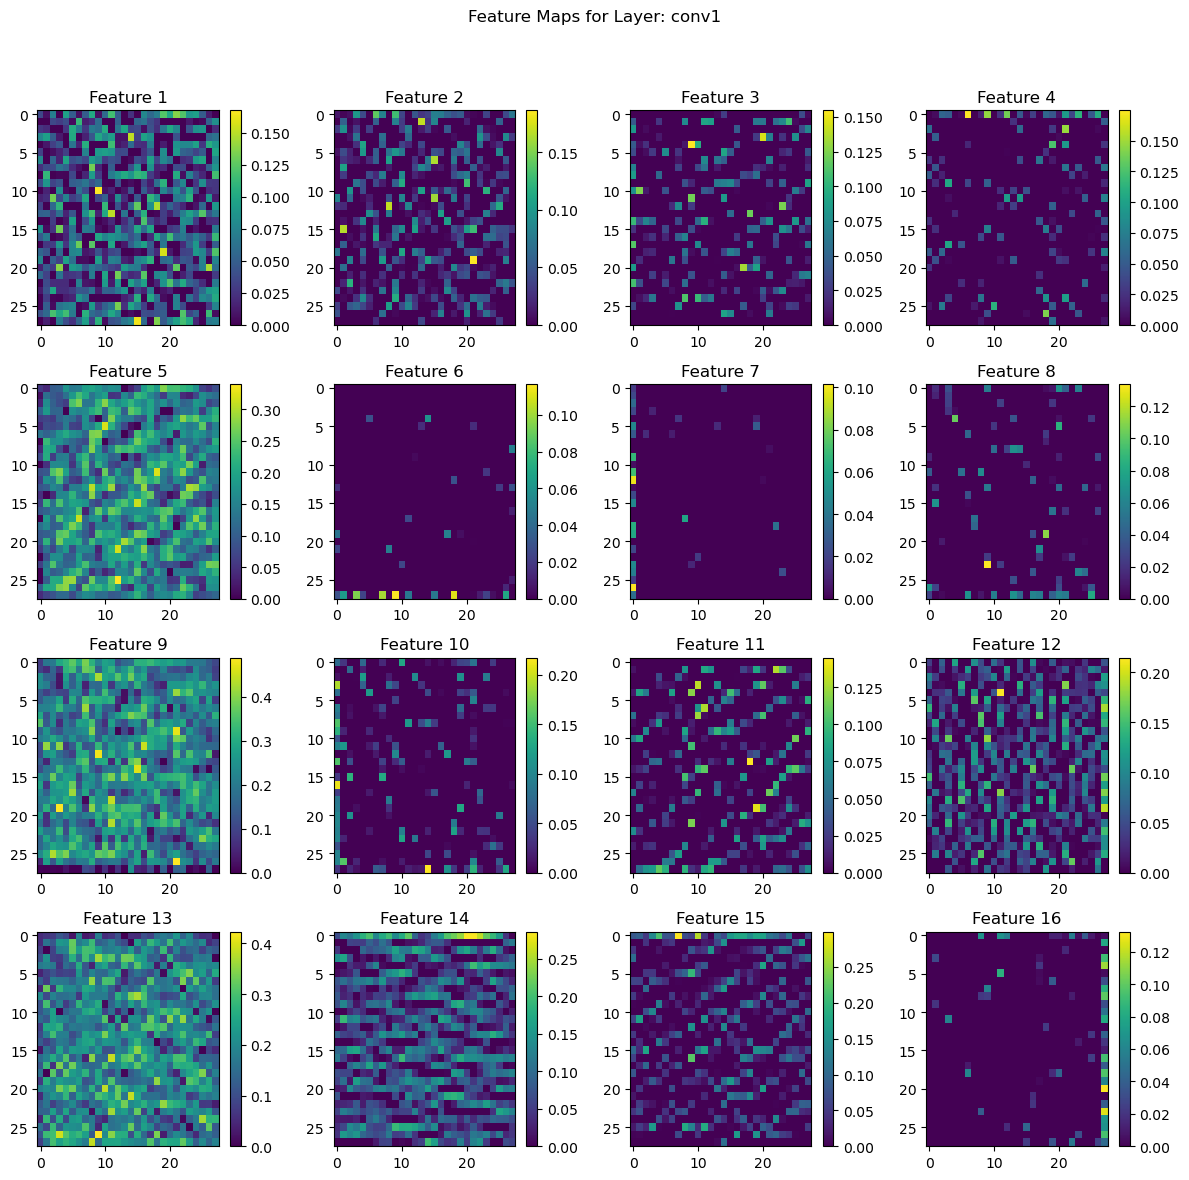

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Feature map shape for conv2: (1, 14, 14, 64)


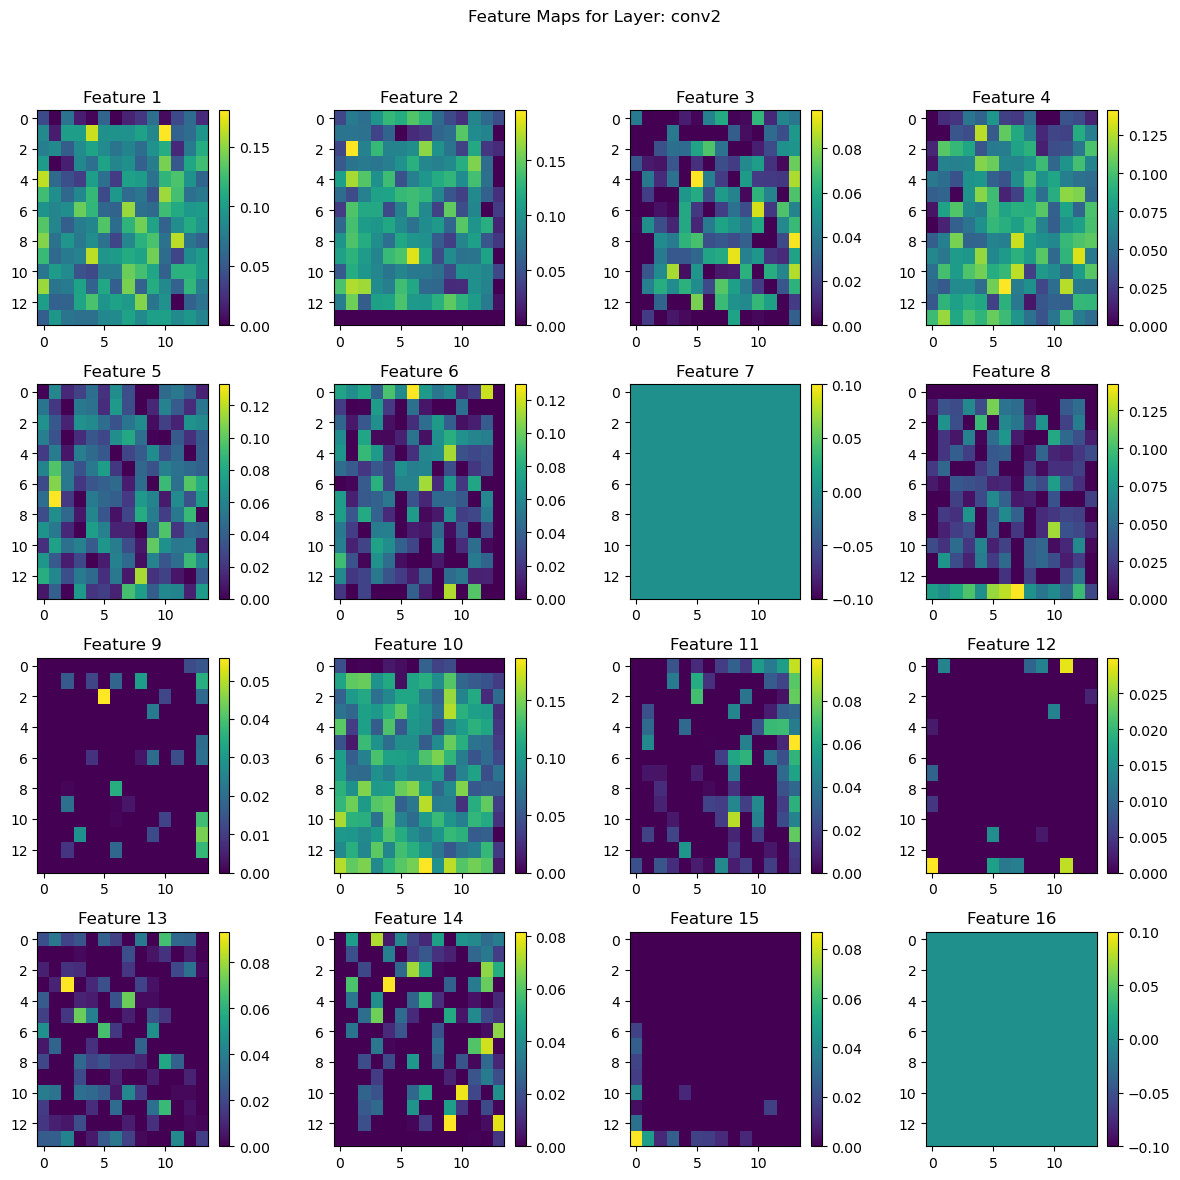

No attention layer found in the model
Visualizations completed successfully!


In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns

def quick_fix_visualizations(model, X_test):
    """
    Function to quickly fix the visualization error and generate feature maps and attention visualizations
    
    Parameters:
    - model: The trained model 
    - X_test: Test data samples
    """
    # Take just one sample
    X_sample = X_test[0:1]
    
    # Fix the feature maps visualization
    visualize_feature_maps_fixed(model, X_sample)
    
    # Fix the attention weights visualization
    interpret_attention_weights_fixed(model, X_sample)
    
    print("Visualizations completed successfully!")

def visualize_feature_maps_fixed(model, X_sample, layer_names=None):
    """Fixed version of visualize_feature_maps function"""
    if layer_names is None:
        # Find all convolutional layers
        layer_names = [layer.name for layer in model.layers if 'conv' in layer.name.lower()]
    
    if not layer_names:
        print("No convolutional layers found in the model")
        return
    
    print(f"Found convolutional layers: {layer_names}")
    
    # Create feature extraction models
    feature_models = {}
    for layer_name in layer_names:
        try:
            feature_models[layer_name] = Model(
                inputs=model.input,
                outputs=model.get_layer(layer_name).output
            )
            print(f"Created feature model for {layer_name}")
        except Exception as e:
            print(f"Error creating feature model for layer {layer_name}: {str(e)}")
    
    # Process each layer
    for layer_name, feature_model in feature_models.items():
        try:
            # Get feature maps for this layer
            feature_map = feature_model.predict(X_sample)
            print(f"Feature map shape for {layer_name}: {feature_map.shape}")
            
            # Get number of features in this layer
            n_features = feature_map.shape[-1]
            
            # Plot up to 16 features in a 4x4 grid
            n_cols = min(4, n_features)
            n_rows = min(4, (n_features + n_cols - 1) // n_cols)
            
            plt.figure(figsize=(n_cols * 3, n_rows * 3))
            plt.suptitle(f'Feature Maps for Layer: {layer_name}')
            
            for i in range(min(n_rows * n_cols, n_features)):
                plt.subplot(n_rows, n_cols, i + 1)
                
                # For 1D CNN output (batch, timesteps, channels)
                if len(feature_map.shape) == 3:
                    # Get the feature for visualization
                    feat = feature_map[0, :, i]
                    
                    # Display as line plot instead of imshow
                    plt.plot(feat)
                    plt.title(f'Feature {i+1}')
                    plt.xlabel('Time Step')
                    plt.ylabel('Activation')
                # For 2D CNN output (batch, height, width, channels)
                elif len(feature_map.shape) == 4:
                    plt.imshow(feature_map[0, :, :, i], aspect='auto', cmap='viridis')
                    plt.title(f'Feature {i+1}')
                    plt.colorbar()
                
                plt.tight_layout()
            
            plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for suptitle
            plt.savefig(f'feature_maps_{layer_name}.png', dpi=300)
            plt.show()
            
        except Exception as e:
            print(f"Error visualizing features for layer {layer_name}: {str(e)}")
            import traceback
            traceback.print_exc()

def interpret_attention_weights_fixed(model, X_sample, attention_layer_name=None):
    """Fixed version of interpret_attention_weights function"""
    # Find attention layer if not specified
    if attention_layer_name is None:
        attention_layer_names = [layer.name for layer in model.layers if 'attention' in layer.name.lower()]
        if not attention_layer_names:
            print("No attention layer found in the model")
            return
        attention_layer_name = attention_layer_names[0]
    
    print(f"Analyzing attention layer: {attention_layer_name}")
    
    try:
        # Create a model that outputs attention layer output
        attention_output_model = Model(
            inputs=model.input,
            outputs=model.get_layer(attention_layer_name).output
        )
        
        # Get the attention layer outputs
        attention_output = attention_output_model.predict(X_sample)
        print(f"Attention output shape: {attention_output.shape}")
        
        # Visualize attention outputs as line plots instead of images
        plt.figure(figsize=(10, 6))
        
        # If output is 3D (batch, timesteps, features)
        if len(attention_output.shape) == 3:
            # Plot mean activation across features
            mean_activation = np.mean(attention_output[0], axis=1)
            plt.plot(mean_activation)
            plt.title(f'Mean Attention Activation for Layer: {attention_layer_name}')
            plt.xlabel('Timestep')
            plt.ylabel('Mean Activation')
            
            # Also plot first few individual feature activations
            num_features = min(5, attention_output.shape[2])
            plt.figure(figsize=(12, 8))
            for i in range(num_features):
                plt.subplot(num_features, 1, i+1)
                plt.plot(attention_output[0, :, i])
                plt.title(f'Feature {i+1} Activations')
                plt.xlabel('Timestep')
                plt.ylabel('Activation')
            
            plt.tight_layout()
            plt.savefig('attention_feature_activations.png', dpi=300)
            plt.show()
            
        else:
            # For other shapes, try to visualize as appropriate
            plt.plot(attention_output[0].flatten())
            plt.title(f'Attention Layer Activations: {attention_layer_name}')
            plt.xlabel('Index')
            plt.ylabel('Activation')
            plt.savefig(f'attention_layer_{attention_layer_name}.png', dpi=300)
            plt.show()
    
    except Exception as e:
        print(f"Error visualizing attention for layer {attention_layer_name}: {str(e)}")
        import traceback
        traceback.print_exc()

def main():
    """
    Main function to demonstrate the visualization utilities
    
    This function shows how to use the visualization functions with a sample model
    """
    try:
        # Check if TensorFlow is available
        print(f"TensorFlow version: {tf.__version__}")
        
        # Example: Create a simple CNN model for demonstration
        def create_sample_model(input_shape=(28, 28, 1)):
            """Create a simple CNN model with attention for demonstration"""
            inputs = tf.keras.layers.Input(shape=input_shape)
            
            # Add convolutional layers
            x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1')(inputs)
            x = tf.keras.layers.MaxPooling2D((2, 2))(x)
            x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2')(x)
            x = tf.keras.layers.MaxPooling2D((2, 2))(x)
            
            # Add attention mechanism
            attention = tf.keras.layers.Dense(1, activation='tanh', name='attention_dense')(x)
            attention = tf.keras.layers.Reshape((attention.shape[1] * attention.shape[2],))(attention)
            attention = tf.keras.layers.Activation('softmax', name='attention_weights')(attention)
            attention = tf.keras.layers.Reshape((attention.shape[1], 1))(attention)
            
            # Flatten and add dense layers
            x = tf.keras.layers.Flatten()(x)
            x = tf.keras.layers.Dense(128, activation='relu')(x)
            outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
            
            # Create model
            model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
            
            return model
        
        # Create a sample model
        sample_model = create_sample_model()
        print("Sample model created:")
        sample_model.summary()
        
        # Generate random test data
        X_test = np.random.rand(10, 28, 28, 1)
        
        # Run the visualization functions
        print("\nRunning quick_fix_visualizations...")
        quick_fix_visualizations(sample_model, X_test)
        
    except Exception as e:
        print(f"Error in main function: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

In [12]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model

# Define the AttentionLayer class first (needed for custom layer loading)
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.attention_weights = self.add_weight(
            name='attention_weights',
            shape=(input_shape[-1], 1),
            initializer='glorot_uniform',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs):
        # Calculate attention scores
        attention_score = tf.matmul(inputs, self.attention_weights)
        attention_weights = tf.nn.softmax(attention_score, axis=1)
        context_vector = inputs * attention_weights
        return context_vector
    
    def compute_output_shape(self, input_shape):
        return input_shape

# Load the model
checkpoint_dir = 'model_checkpoints'
checkpoint_path = os.path.join(checkpoint_dir, 'best_hybrid_model.h5')

if os.path.exists(checkpoint_path):
    model = load_model(checkpoint_path, custom_objects={'AttentionLayer': AttentionLayer})
    print(f"Model loaded successfully from: {checkpoint_path}")
    
    # Now you can save the model
    save_path = 'hybrid_ecg_model.h5'
    model.save(save_path)
    print(f"Model saved to: {save_path}")
else:
    print("Model checkpoint not found. Need to train the model first.")

Model loaded successfully from: model_checkpoints\best_hybrid_model.h5
Model saved to: hybrid_ecg_model.h5
